## Setup & Dependencies

In [2]:
!pip install tqdm
!pip install -U "ray[tune]"
!pip install --user fastai

  Using cached msgpack-1.0.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (299 kB)
  Using cached filelock-3.8.0-py3-none-any.whl (10 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
  Using cached distlib-0.3.6-py2.py3-none-any.whl (468 kB)


In [3]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import torch
import multiprocessing

from fastai.text.all import *

import sys

In [4]:
# Number of CPU cores available
cpu = multiprocessing.cpu_count()

# Set up cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of GPUs being used
gpu = torch.cuda.device_count() if torch.cuda.is_available() else 0

# CPU and GPU Resources
proc_resources = {'cpu': cpu, 'gpu': gpu}

repo_path = "/home/jupyter/src/natalies-little-helper/"
data_path = repo_path + "data/"
model_path = repo_path + "models/"

## Data Preprocessing

In [5]:
train = pd.read_csv(data_path + 'Tweets.csv')
train = train[train['negativereason'].notna()].reset_index(drop=True)
train.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [6]:
train = train[['text', 'negativereason']]

In [7]:
train.head()

,text,negativereason
0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",Bad Flight
1,@VirginAmerica and it's a really big bad thing about it,Can't Tell
2,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,Can't Tell
3,@VirginAmerica SFO-PDX schedule is still MIA.,Late Flight
4,@VirginAmerica I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!,Bad Flight


## ULMFiT Utils

In [11]:
def train_lm(train_data, show_batch=False, metrics=[accuracy, Perplexity()], wd=0.1, epochs=(6,6)):
    # Data Loader
    lang_dls = DataBlock(blocks=(TextBlock.from_df('text', is_lm=True)),
                 get_x=ColReader('text'),
                 splitter=RandomSplitter(valid_pct=0.2))
    lang_dls = lang_dls.dataloaders(train_data, bs=64, seq_len=72, device=torch.device('cuda'))
    lang_dls.show_batch(max_n=4)
    
    # Train LM
    learn = language_model_learner(lang_dls, AWD_LSTM, metrics=metrics, wd=wd).to_fp16()
    
    # First cycle
    lr = learn.lr_find()
    learn.fit_one_cycle(epochs[0], lr.valley, moms=(0.85,0.8,0.75))
    
    # Second cycle
    learn.unfreeze()
    lr = learn.lr_find();
    learn.fit_one_cycle(epochs[1], lr.valley, moms=(0.8,0.75,0.7))
    
    return learn, lang_dls
    
def test_lm(learner, text, n_words, n_sentences):
    print("\n".join(learner.predict(text, n_words, temperature=0.75) for _ in range(n_sentences)))
    
def train_classifier(train_data, lang_dls, encoder_path, label, show_batch=False, metrics=[accuracy, Perplexity()], wd=0.1, epochs=(4, 4, 9)):
    intent_dls = DataBlock(blocks=(TextBlock.from_df('text', vocab=lang_dls.vocab, seq_len=72), CategoryBlock),
                 get_x=ColReader('text'),
                 get_y=ColReader(label),
                 splitter=RandomSplitter(valid_pct=0.2))

    intent_dls = intent_dls.dataloaders(train_data, bs=64, device=torch.device('cuda'))
    intent_dls.show_batch(max_n=4)
    
    learn = text_classifier_learner(intent_dls, AWD_LSTM, metrics=metrics, wd=wd, drop_mult=0.5).to_fp16()
    learn.load_encoder(encoder_path)
    
    # First cycle
    lr = learn.lr_find()
    learn.fit_one_cycle(epochs[0], lr.valley, moms=(0.8,0.75,0.7))
    
    # Second cycle
    learn.freeze_to(-2)
    lr = learn.lr_find()
    learn.fit_one_cycle(epochs[1], lr, moms=(0.8,0.75,0.7))
    # learn.fit_one_cycle(epochs, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.75,0.7))
    
    # Last cycle
    learn.unfreeze()
    lr = learn.lr_find()
    learn.fit_one_cycle(epochs[2], slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.75,0.7))
    # learn.fit_one_cycle(epochs, lr, moms=(0.8,0.75,0.7))
    
    return learn

def test_classifier_acc(learn):
    pred_fwd,lbl_fwd = learn.get_preds()
    return accuracy(pred_fwd, lbl_fwd)
    

# Base Trainer

## Train ULMFiT Language Model

In [61]:
lang_dls = DataBlock(blocks=(TextBlock.from_df('text', is_lm=True)),
                 get_x=ColReader('text'),
                 splitter=RandomSplitter(valid_pct=0.2))

In [62]:
lang_dls = lang_dls.dataloaders(train, bs=64, seq_len=72, device=torch.device('cuda'))
lang_dls.show_batch(max_n=4)

,text,text_
0,"xxbos @usairways a year and every time with xxup us xxmaj air something happens . i sat waiting for a re - scheduled flight for 10 hours then to say its xxbos @southwestair thanks , but they told him he could n’t a few hours ago , then my plane left after i tried to do it . xxmaj stuck waiting for hours now xxbos @southwestair xxmaj for example , ca n't","@usairways a year and every time with xxup us xxmaj air something happens . i sat waiting for a re - scheduled flight for 10 hours then to say its xxbos @southwestair thanks , but they told him he could n’t a few hours ago , then my plane left after i tried to do it . xxmaj stuck waiting for hours now xxbos @southwestair xxmaj for example , ca n't pay"
1,the location i paid to get to and now … . xxbos @usairways link does n't work and xxmaj i 've tried tracking my bag several times . xxmaj still does n't clarify where it is . xxbos @united still sitting here waiting for a plane … xxunk hours wasted xxbos @americanair crew did the best they could but it was out of their control . xxmaj you only get one chance,location i paid to get to and now … . xxbos @usairways link does n't work and xxmaj i 've tried tracking my bag several times . xxmaj still does n't clarify where it is . xxbos @united still sitting here waiting for a plane … xxunk hours wasted xxbos @americanair crew did the best they could but it was out of their control . xxmaj you only get one chance of
2,do n't xxunk terms and conditions . # xxunk xxbos @usairways 5 hour cross country morning flight and you have no food ? # badservice xxbos @virginamerica for all my flight stuff wrong and did nothing about it . xxmaj had # worst # flight ever xxbos @united @ny_njairports xxmaj only at xxmaj newark can you land 15 minutes early but lose all that time waiting on tarmac for a gate .,n't xxunk terms and conditions . # xxunk xxbos @usairways 5 hour cross country morning flight and you have no food ? # badservice xxbos @virginamerica for all my flight stuff wrong and did nothing about it . xxmaj had # worst # flight ever xxbos @united @ny_njairports xxmaj only at xxmaj newark can you land 15 minutes early but lose all that time waiting on tarmac for a gate . xxbos
3,". xxmaj might miss connection xxbos @southwestair - been on hold forever . xxmaj my first flight was xxmaj cancelled xxmaj flightled but my 2nd flight is still on time - xxup help ! xxbos @united xxmaj lovely new plane from xxup lga to xxup ord but no power outlets ? xxbos @americanair , i was told my flights xxunk & & xxunk was xxmaj cancelled xxmaj flightled . xxmaj but i","xxmaj might miss connection xxbos @southwestair - been on hold forever . xxmaj my first flight was xxmaj cancelled xxmaj flightled but my 2nd flight is still on time - xxup help ! xxbos @united xxmaj lovely new plane from xxup lga to xxup ord but no power outlets ? xxbos @americanair , i was told my flights xxunk & & xxunk was xxmaj cancelled xxmaj flightled . xxmaj but i do"


In [63]:
learn = language_model_learner(lang_dls, AWD_LSTM, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()

In [64]:
# learn.fit_one_cycle(1, 1e-2)

0.0030199517495930195


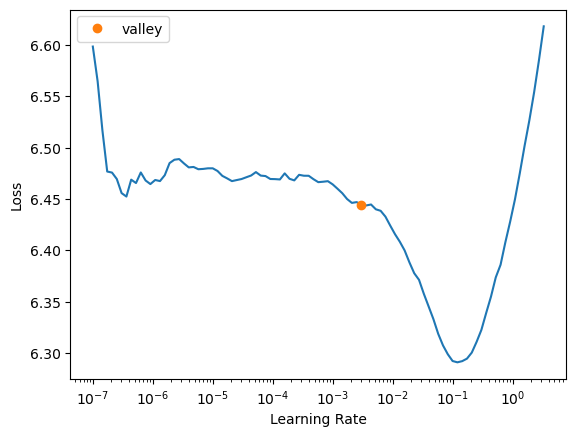

In [65]:
# #find the optimal learning rate & visualize it
lr = learn.lr_find()
print(lr.valley)
# learn.recorder.plot(skip_end=15);

In [66]:
epochs = 6
learn.fit_one_cycle(epochs, lr.valley, moms=(0.85,0.8,0.75))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.379665,5.913874,0.159537,370.137177,00:12
1,6.110925,5.557249,0.184868,259.109070,00:12
2,5.931389,5.467914,0.188842,236.965271,00:12
3,5.849389,5.445411,0.189161,231.692535,00:12
4,5.807628,5.438148,0.189299,230.015701,00:12
5,5.785289,5.437185,0.189244,229.794464,00:12


In [67]:
learn.unfreeze()
lr = learn.lr_find();
print(lr.valley)

epochs = 6
learn.fit_one_cycle(epochs, lr.valley, moms=(0.8,0.75,0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.973240,4.482364,0.236794,88.443481,00:13
1,4.680242,4.518961,0.237046,91.740273,00:13
2,4.461723,4.244164,0.261873,69.697472,00:13
3,4.283230,4.208779,0.266844,67.274338,00:13
4,4.155985,4.210586,0.267223,67.395996,00:13


In [68]:
TEXT = "@southwestair My flight was delayed"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

@southwestair My flight was delayed and i call to Phoenix . She also came from the airport to JFK , so now the flight is Cancelled Vegan . Or is it on time ? sf That 's
@southwestair My flight was delayed due to weather , but i disgruntled lose my bags . Such a poor experience with you . 4567 NO NONSENSE .. This is the first time i have ever done this . You


In [69]:
#Save fine-tuned model for future use
learn.save_encoder(repo_path + '/models/ULMFiT_fine_tuned_LM')

## Train UlmFiT Classifier

In [70]:
intent_dls = DataBlock(blocks=(TextBlock.from_df('text', vocab=lang_dls.vocab, seq_len=72), CategoryBlock),
                 get_x=ColReader('text'),
                 get_y=ColReader('negativereason'),
                 splitter=RandomSplitter(valid_pct=0.2))

intent_dls = intent_dls.dataloaders(train, bs=64, device=torch.device('cuda'))
intent_dls.show_batch(max_n=4)

,text,category
0,xxbos @usairways xxup plans xxup changed ! xxup is xxup that xxup what u xxup call xxup not xxup xxunk xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection ! # seriously,Customer Service Issue
1,xxbos @united xxunk 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over xxrep 3 !,Flight Booking Problems
2,"xxbos @southwestair xxmaj loved one 's flight xxup atl to xxup ind xxmaj cancelled xxmaj flightled due to "" ice in xxmaj indy "" . xxmaj sitting here in xxmaj indy , it is xxunk dry . xxmaj tomorrow 4 - 6 "" of snow .",Cancelled Flight
3,"xxbos .@americanair ( 2 / 3 ) … i sat on the runway for 4 xxup more xxup hrs b4 takeoff ( 10 hrs xxmaj late xxmaj flight , xxunk xxup am ) . xxmaj pilot xxunk stated it was a comp / mech issue .",Late Flight


In [71]:
# intent_dls = DataBlock(blocks=(TextBlock.from_df('text', vocab=dls.vocab, seq_len=72), CategoryBlock),
#                  get_x=ColReader('text'),
#                  get_y=ColReader('negativereason'),
#                  splitter=RandomSplitter(valid_pct=0.2))
# intent_dls.summary(train, show_batch=True)

In [72]:
encoder_path = repo_path + '/models/ULMFiT_fine_tuned_LM'
learn = text_classifier_learner(intent_dls, AWD_LSTM, metrics=[accuracy, Perplexity()], wd=0.1, drop_mult=0.5).to_fp16()
learn.load_encoder(encoder_path)

0.033113110810518265


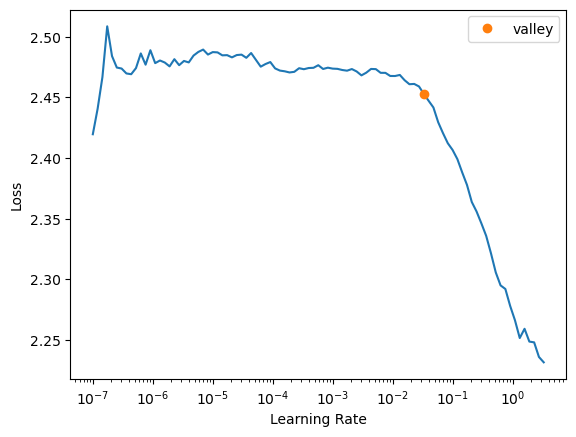

In [73]:
lr = learn.lr_find()
print(lr.valley)

In [74]:
epochs = 4
learn.fit_one_cycle(epochs, lr.valley, moms=(0.8,0.75,0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.016033,1.764095,0.415259,5.836287,00:03
1,1.712189,1.549522,0.494278,4.709217,00:03
2,1.617195,1.503480,0.496458,4.497313,00:04
3,1.586575,1.497118,0.502452,4.468793,00:03


In [75]:
learn.freeze_to(-2)
# lr = learn.lr_find()
# print(lr.valley)

In [ ]:
epochs = 4
# learn.fit_one_cycle(epochs, lr.valley, moms=(0.8,0.75,0.7))

learn.fit_one_cycle(epochs, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.75,0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.548373,1.419105,0.528065,4.133419,00:04
1,1.450379,1.347682,0.555858,3.848496,00:04
2,1.378141,1.326074,0.560218,3.766229,00:04
3,1.335881,1.319024,0.565123,3.739769,00:03


In [ ]:
learn.unfreeze()
# lr = learn.lr_find()
# print(lr.valley)

In [81]:
# learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
epochs = 9
# learn.fit_one_cycle(epochs, lr.valley, moms=(0.8,0.75,0.7))
learn.fit_one_cycle(epochs, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.75,0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.053360,1.182740,0.610899,3.263304,00:05
1,1.044068,1.169878,0.615804,3.221600,00:05
2,0.968947,1.159670,0.620708,3.188880,00:05
3,0.905051,1.159421,0.624523,3.188087,00:05
4,0.874813,1.168784,0.617439,3.218079,00:05


In [82]:
learn.save(repo_path + '/models/ULMFiT_intent_class')

Path('/home/jupyter/src/natalies-little-helper/models/ULMFiT_intent_class.pth')

In [83]:
pred_fwd,lbl_fwd = learn.get_preds()
accuracy(pred_fwd, lbl_fwd)

TensorBase(0.6174)

# Grouped Intents

## Language Model

In [17]:
intentSubGroups = {
    'Customer Service Issue': 'Customer Service Issue',
    'Late Flight': 'Late Flight',
    'Cancelled Flight': 'Cancelled Flight',
    'Lost Luggage': 'Luggage',
    'Bad Flight': 'Bad Flight',
    'Flight Booking Problems': 'Flight Booking Problems',
    'Flight Attendant Complaints': 'Flight Attendant Complaints',
    'longlines': 'Customer Service Issue',
    'Damaged Luggage': 'Luggage',
    'Can\'t Tell': 'Can\'t Tell'
}
train['intentGroup'] = train.negativereason.apply(lambda x: intentSubGroups[x])

,text,text_
0,"xxbos @united xxmaj i 'm not as sure as you are . http : / / t.co / xxunk xxbos @southwestair xxmaj there is no option just to xxmaj cancelled xxmaj flight ? i do n't want to change flight , i want to xxmaj cancelled xxmaj flight . xxbos @americanair xxunk "" the wheel was broken when we got it . xxmaj we xxunk . "" xxbos @jetblue xxmaj they did","@united xxmaj i 'm not as sure as you are . http : / / t.co / xxunk xxbos @southwestair xxmaj there is no option just to xxmaj cancelled xxmaj flight ? i do n't want to change flight , i want to xxmaj cancelled xxmaj flight . xxbos @americanair xxunk "" the wheel was broken when we got it . xxmaj we xxunk . "" xxbos @jetblue xxmaj they did not"
1,"@united i am calling to check on a future flight and your first agent hung up and now you sent me to the xxunk travel line ! ! xxmaj this is xxup hell ! ! xxbos @americanair aa employees were rude and unwilling to help . 10 , xxrep 3 0 miles is a rotten cherry on top of a dog shit xxmaj sunday . # xxunk xxbos @usairways - on hold","i am calling to check on a future flight and your first agent hung up and now you sent me to the xxunk travel line ! ! xxmaj this is xxup hell ! ! xxbos @americanair aa employees were rude and unwilling to help . 10 , xxrep 3 0 miles is a rotten cherry on top of a dog shit xxmaj sunday . # xxunk xxbos @usairways - on hold 45"
2,"i have a place to stay tonight ? xxmaj can you respond to me here so i can go back to sleep ? xxbos @united 32 people getting pretty tired about no action on xxunk the problem plus missing a day of vacation and skiing xxbos @usairways charged my card 11 times for one airline ticket , now card is on security hold xxbos @americanair xxunk xxmaj two hour wait for xxunk","have a place to stay tonight ? xxmaj can you respond to me here so i can go back to sleep ? xxbos @united 32 people getting pretty tired about no action on xxunk the problem plus missing a day of vacation and skiing xxbos @usairways charged my card 11 times for one airline ticket , now card is on security hold xxbos @americanair xxunk xxmaj two hour wait for xxunk as"
3,"@usairways your service in xxmaj philly is unacceptable . xxmaj look into better service ✌ ️ a 16 yr old should nt have a hard time http : / / t.co / xxunk xxbos @americanair not only did you rebook me on the wrong day , your phone system says it ca n't handle the volume and hangs up on me xxrep 3 ! xxbos @usairways you ca n't control the weather","your service in xxmaj philly is unacceptable . xxmaj look into better service ✌ ️ a 16 yr old should nt have a hard time http : / / t.co / xxunk xxbos @americanair not only did you rebook me on the wrong day , your phone system says it ca n't handle the volume and hangs up on me xxrep 3 ! xxbos @usairways you ca n't control the weather but"


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.380895,5.949142,0.156737,383.424408,00:12
1,6.148376,5.597788,0.182185,269.828979,00:12
2,5.967096,5.486746,0.187620,241.470261,00:12
3,5.869460,5.456770,0.188448,234.339279,00:12
4,5.819797,5.447142,0.189130,232.093811,00:12
5,5.793656,5.445720,0.189156,231.764130,00:12


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.463944,4.897407,0.206593,133.942032,00:13
1,5.118612,4.632112,0.227439,102.730804,00:13
2,4.909031,4.529360,0.236264,92.699242,00:13
3,4.780428,4.485791,0.241504,88.747101,00:13
4,4.708477,4.469524,0.242691,87.315140,00:13
5,4.673602,4.465062,0.243597,86.926392,00:13


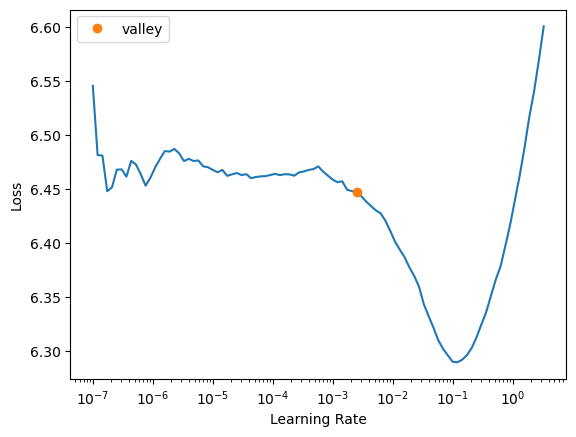

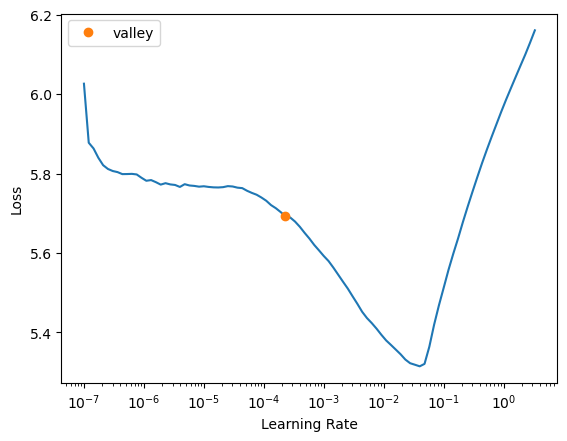

In [151]:
lm_learner, lang_dls = train_lm(train, show_batch=True, epochs=(6,6))

In [152]:
text = 'There was a delay on my flight'
n_words = 40
n_sentences = 4
test_lm(lm_learner, text, n_words, n_sentences)

There was a delay on my flight since 😂 . i meant to t the lack of support for my belt . Happened to the second time him and the rest of the runway on Wednesday . No sign on your phone .
There was a delay on my flight to New York . First time to go to a sign , the cause is the United Cancelled Flight . My flight was stopped and i was gone . It 's a
There was a delay on my flight to JFK because of a United Airlines flight under the bridge at AIRPLANE . The second time does not happen . The plane is still in Boston . Alive . Never
There was a delay on my flight from Chicago to Chicago . But still no clear route to NY . No one gives my seat . Not the problem . shameful What is the meaning of this ? i


In [153]:
#Save fine-tuned model for future use
acc = 'temp'
lm_learner.save_encoder(f'{model_path}ULMFiT_fine_tuned_LM_{acc}')

## Train Classifier

,text,category
0,xxbos @united xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag xxrep 3 ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,Luggage
1,xxbos @usairways xxup plans xxup changed ! xxup is xxup that xxup what u xxup call xxup not xxup xxunk xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection ! # seriously,Customer Service Issue
2,xxbos @united - xxup seriously it 's 2015 ? ! ? ! xxup no wifi on a xxunk flight from xxup cle - sfo # xxunk . xxmaj you 're the xxup only airline w / out wifi … and pls no ' xxunk ' xxup bs .,Bad Flight
3,xxbos @united xxunk 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over xxrep 3 !,Flight Booking Problems


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.897414,1.640841,0.430518,5.159505,00:03
1,1.643181,1.443803,0.508447,4.236778,00:03
2,1.546637,1.397149,0.521526,4.043656,00:04
3,1.542685,1.392490,0.525341,4.024859,00:04


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.387732,1.260625,0.562943,3.527627,00:04
1,1.223063,1.104243,0.617439,3.016940,00:04
2,1.075694,1.025256,0.643597,2.787810,00:04
3,0.933749,0.989751,0.655041,2.690565,00:04


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.897903,0.995204,0.655586,2.705277,00:05
1,0.849730,0.991397,0.651226,2.694998,00:05
2,0.816539,0.989415,0.652861,2.689660,00:05
3,0.761794,0.999196,0.657221,2.716097,00:05
4,0.710097,0.995935,0.662125,2.707254,00:05
5,0.658357,1.005677,0.659945,2.733757,00:05
6,0.613795,1.012233,0.653951,2.751738,00:05
7,0.590914,1.009809,0.659401,2.745078,00:05
8,0.580897,1.019354,0.659401,2.771403,00:05


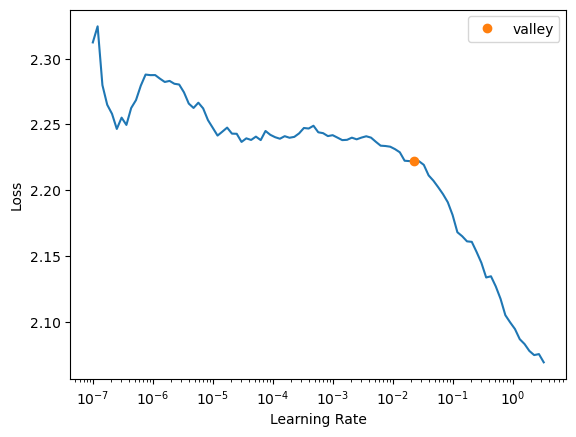

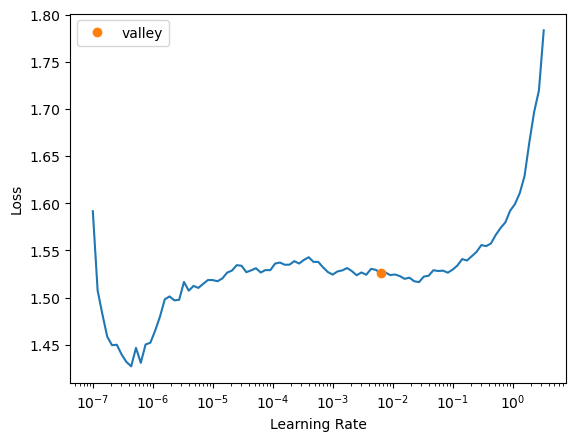

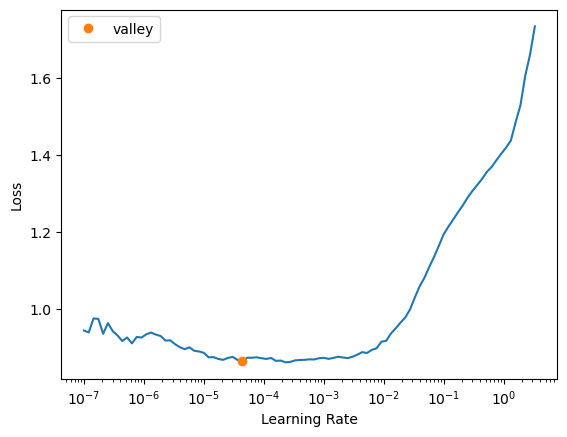

In [154]:
encoder_path = model_path + 'ULMFiT_fine_tuned_LM'
classifier = train_classifier(train, lang_dls, encoder_path, label='intentGroup')

In [155]:
acc = test_classifier_acc(classifier)
print(acc)

TensorBase(0.6594)


In [156]:
acc = test_classifier_acc(classifier)
classifier.save(f'{model_path}ULMFiT_intent_class_{acc.item()}')

Path('/home/jupyter/src/natalies-little-helper/models/ULMFiT_intent_class_0.6594005227088928.pth')

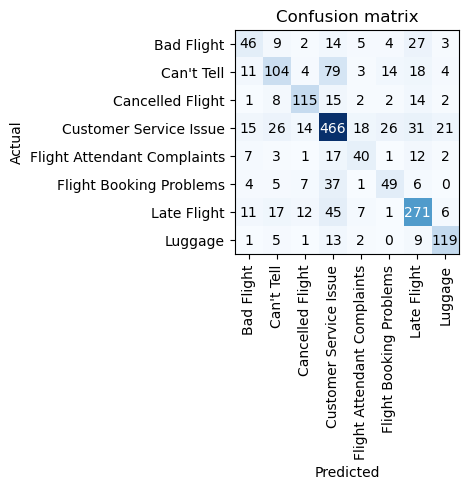

In [157]:
interp = ClassificationInterpretation.from_learner(classifier)
interp.plot_confusion_matrix()

# Clean Data Intents

## Clean Data

In [20]:
clean_data = train.copy()

In [21]:
# Remove HTML tags
clean_data['text'] = clean_data['text'].apply(lambda x: re.sub(r'<[^<]+?>', ' ', x))

# Remove URLs
clean_data['text'] = clean_data['text'].apply(
    lambda x: re.sub(r'\s*https?:\/\/\S+(\s+|$)', ' ', x))

# Remove handles
clean_data['text'] = clean_data['text'].apply(
    lambda x: re.sub("(?<=@)[A-Za-z0-9_]+","", x))
    # lambda x: re.sub("@[A-Za-z0-9_]+","", x))

# Remove hashtags
clean_data['text'] = clean_data['text'].apply(
        lambda x: re.sub("(?<=#)[A-Za-z0-9_]+","", x))
    # lambda x: re.sub("(?<=#)[A-Za-z0-9_]+","", x))
    # lambda x: re.sub("#[A-Za-z0-9_]+","", x))

# Remove non-alphabetic chars
# clean_data['text'] = clean_data['text'].apply(
#     lambda x: re.sub(r'[^a-zA-Z\s]+', ' ', x))

# Remove extra spaces
clean_data['text'] = clean_data['text'].apply(
    lambda x: re.sub(r'\s+', ' ', x))

## Train Language Model

,text,text_
0,"xxbos @ i now learned that customer service at xxup sxm works for the airport , not jetblue . xxmaj they need a supervisor to do anything . xxbos @ xxmaj cancelled xxmaj flightling flights due to winter weather is totally understandable , but it would sure be nice if you would answer your phones . xxbos @ are people going to answer our calls ? xxbos @ getting the run around","@ i now learned that customer service at xxup sxm works for the airport , not jetblue . xxmaj they need a supervisor to do anything . xxbos @ xxmaj cancelled xxmaj flightling flights due to winter weather is totally understandable , but it would sure be nice if you would answer your phones . xxbos @ are people going to answer our calls ? xxbos @ getting the run around today"
1,xxmaj million xxmaj miler xxmaj i 've been delayed plenty . xxup never in the xxunk xxunk does it . xxmaj i 'd be embarrassed to be xxunk . xxbos @ you flew me into xxmaj chi instead and i got a ride to xxup mke . u said my bags would go to xxup mke today . xxmaj is it on the xxmaj cancelled xxmaj flightled flight tho ? xxbos @,million xxmaj miler xxmaj i 've been delayed plenty . xxup never in the xxunk xxunk does it . xxmaj i 'd be embarrassed to be xxunk . xxbos @ you flew me into xxmaj chi instead and i got a ride to xxup mke . u said my bags would go to xxup mke today . xxmaj is it on the xxmaj cancelled xxmaj flightled flight tho ? xxbos @ it
2,system ? # xxbos @ yes of course i have . xxmaj is this how you treat customer with no recourse ? xxbos @ flight is delayed 5 hours . xxmaj no reason given . xxmaj sure love flying with your airline . # xxbos @ nothing you can do to help us restore some barely - expired # points ? xxbos @ xxup you xxup guys xxup are xxup horrible .,? # xxbos @ yes of course i have . xxmaj is this how you treat customer with no recourse ? xxbos @ flight is delayed 5 hours . xxmaj no reason given . xxmaj sure love flying with your airline . # xxbos @ nothing you can do to help us restore some barely - expired # points ? xxbos @ xxup you xxup guys xxup are xxup horrible . xxbos
3,reach home the nxt day xxbos @ boarding time shows 35 min and your gate agent started at 45 . showed up at xxunk and they had to check bag . xxbos @ xxmaj seriously ? i should keep trying after seven hours . xxmaj that is your corporate policy ? # xxbos @ xxmaj no one answers your reservation phone line . i need to book travel with a companion certificate,home the nxt day xxbos @ boarding time shows 35 min and your gate agent started at 45 . showed up at xxunk and they had to check bag . xxbos @ xxmaj seriously ? i should keep trying after seven hours . xxmaj that is your corporate policy ? # xxbos @ xxmaj no one answers your reservation phone line . i need to book travel with a companion certificate .


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.671499,4.565957,0.191337,96.154533,00:12
1,4.773890,3.972289,0.266661,53.105968,00:12
2,4.339400,3.881091,0.275430,48.477058,00:12
3,4.098305,3.831691,0.279238,46.140495,00:12
4,3.943345,3.807801,0.281635,45.051262,00:12
5,3.845392,3.797505,0.282976,44.589779,00:12
6,3.786347,3.796400,0.282759,44.540543,00:12


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.732963,3.774121,0.287741,43.559216,00:13
1,3.678945,3.721372,0.298582,41.321033,00:13
2,3.613864,3.696491,0.301432,40.305634,00:13
3,3.546915,3.687279,0.303257,39.936031,00:13
4,3.506397,3.677192,0.305487,39.535221,00:13
5,3.467631,3.676396,0.305654,39.503773,00:13
6,3.443081,3.678387,0.305072,39.582493,00:13
7,3.415482,3.676053,0.305842,39.490211,00:13


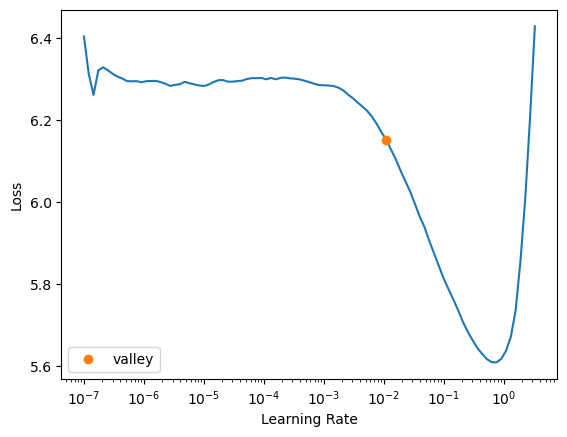

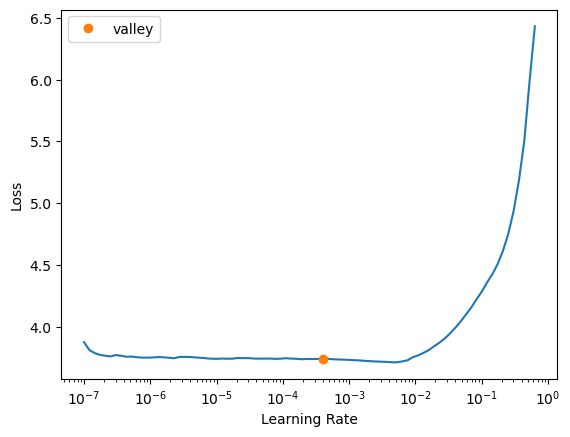

In [12]:
lm_learner_clean, lang_dls_clean = train_lm(clean_data, show_batch=True, epochs=(7,8))

In [25]:
text = 'My flight was delayed'
n_words = 40
n_sentences = 4
test_lm(lm_learner_clean, text, n_words, n_sentences)

My flight was delayed twice ! But i have been on hold for over an hour ! Can i get to JFK or Chicago ? U 've been responding to a joke there ! @ your customer service
My flight was delayed , but i have a flight to San Diego , I 'm NOT KIDDING @ Checkin at LAX did n't have to book until 5 pm . Thanks . @
My flight was delayed due to mechanical issues . We 're in Chicago , Seattle . If you can control that and that is crazy . @ My flight is delayed and I 'm stranded in
My flight was delayed and i need to get a credit , but it 's pretty sad . i have not been able to get a refund for my flight . @ on hold for 1 hour . That 's why #


In [18]:
#Save fine-tuned model for future use
acc = '0.3058_no_hashtags'
lm_learner_clean.save_encoder(f'{model_path}ULMFiT_fine_tuned_LM_clean_{acc}')

## Train Classifier

In [26]:
clean_data = clean_data.groupby('intentGroup').apply(lambda x: x.sample(min(1000, len(x)))).reset_index(drop=True)

,text,category
0,xxbos @ xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag xxrep 3 ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,Luggage
1,xxbos @ xxup xxunk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup xxunk xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup xxunk u xxup and,Bad Flight
2,xxbos @ @ 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over xxrep 3 !,Flight Booking Problems
3,"xxbos .@ ( 2 / 3 ) … i sat on the runway for 4 xxup more xxup hrs b4 takeoff ( 10 hrs xxmaj late xxmaj flight , xxunk xxup am ) . xxmaj pilot xxunk stated it was a comp / mech issue .",Late Flight


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.682004,1.418102,0.528468,4.129277,00:02
1,1.449488,1.342592,0.547715,3.828956,00:02
2,1.337572,1.304948,0.564555,3.687497,00:03
3,1.258496,1.302817,0.566961,3.679648,00:02


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.272965,1.325696,0.542101,3.764806,00:03
1,1.262883,1.292119,0.577386,3.640493,00:03
2,1.157503,1.244099,0.579791,3.469806,00:02
3,1.069540,1.243949,0.575782,3.469286,00:03


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.016272,1.241109,0.579791,3.459448,00:04
1,1.023365,1.250143,0.587009,3.490841,00:04
2,0.982473,1.257841,0.591820,3.517819,00:04
3,0.895659,1.249739,0.596632,3.489433,00:04
4,0.807636,1.259737,0.592622,3.524494,00:04
5,0.715477,1.269698,0.605453,3.559776,00:04
6,0.648632,1.274404,0.599840,3.576569,00:04
7,0.592212,1.275691,0.603047,3.581174,00:04
8,0.566366,1.286208,0.601443,3.619035,00:04


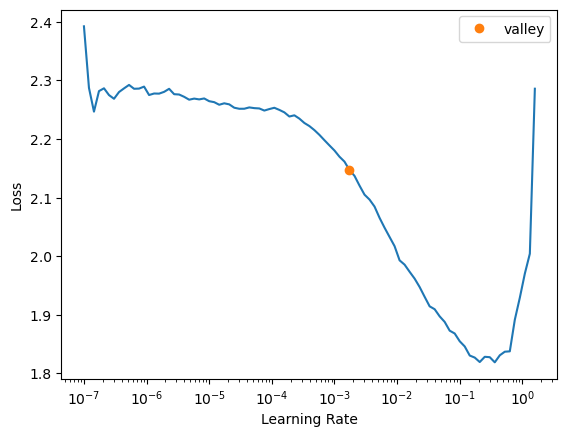

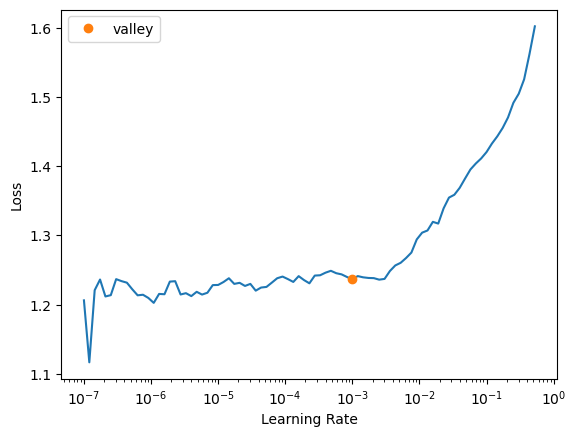

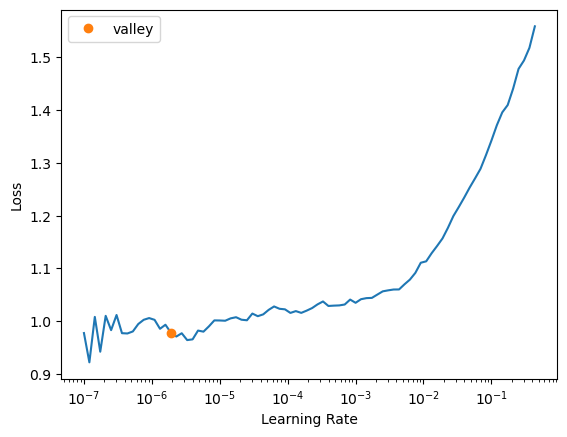

In [27]:
acc = 'temp'
encoder_path = model_path + f'ULMFiT_fine_tuned_LM_clean_{acc}'
classifier = train_classifier(clean_data, lang_dls_clean, encoder_path, label='intentGroup')

In [28]:
acc = test_classifier_acc(classifier)
print(acc)

TensorBase(0.6014)


In [238]:
acc = test_classifier_acc(classifier)
classifier.save(f'{model_path}ULMFiT_intent_class_clean_{acc.item()}')

Path('/home/jupyter/src/natalies-little-helper/models/ULMFiT_intent_class_clean_0.6425068378448486.pth')

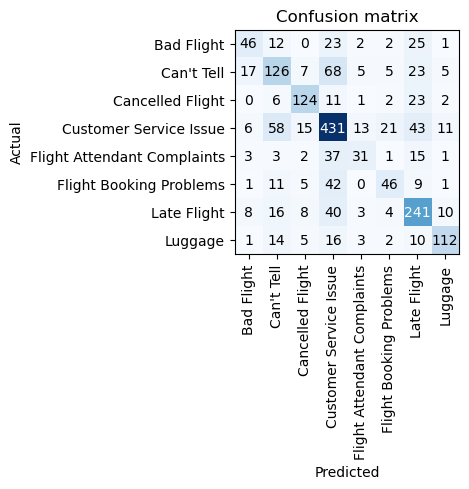

In [24]:
interp = ClassificationInterpretation.from_learner(classifier)
interp.plot_confusion_matrix()